Hypothesis:
On the subj_number task, information will be encoded later for Tagalog, because it uses a seperate word for plural (dependencies), then it will for English, which encodes such information at the POS level.

Plan:
- Load english data for subj_number, and do 'dummy' translation for a subset into Tagalog
- Train 6 probes on mbert: english data on layers 0, 4, 8, tagalog data on layers 0, 4, 8
- Compare probe accuracy on a test set, plot


In [2]:
import os
import urllib.request
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [3]:
def download_probing_data(task_name="past_present", data_dir="./data"):
    """
    Downloads a specific probing task from the SentEval repository.
    task_name options: 'sent_len', 'wc', 'tree_depth', 'top_const', 
                       'past_present', 'subj_number', 'obj_number', 
                       'odd_man_out', 'coord_inv'
    """
    os.makedirs(data_dir, exist_ok=True)
    url = f"https://raw.githubusercontent.com/facebookresearch/SentEval/main/data/probing/{task_name}.txt"
    file_path = os.path.join(data_dir, f"{task_name}.txt")
    
    if not os.path.exists(file_path):
        print(f"Downloading {task_name}...")
        urllib.request.urlretrieve(url, file_path)
        print("Download complete.")
    else:
        print(f"Data for {task_name} already exists.")
    return file_path

In [4]:
class ProbingDataset(Dataset):
    def __init__(self, file_path, partition_filter, tokenizer, max_len=128):
        self.sentences = []
        self.labels = []
        self.tokenizer = tokenizer
        self.max_len = max_len
        
        # SentEval format: "partition \t label \t sentence content..."
        label_set = set()
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) < 3: continue
                
                partition = parts[0]
                label = parts[1]
                text = parts[2]
                
                if partition == partition_filter:
                    self.sentences.append(text)
                    self.labels.append(label)
                    label_set.add(label)
        
        # Create a mapping from label string to integer
        # Note: In a real scenario, ensure this mapping is consistent across train/test
        self.label_map = {l: i for i, l in enumerate(sorted(list(label_set)))}
        self.num_classes = len(self.label_map)
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        text = self.sentences[idx]
        label_str = self.labels[idx]
        label_id = self.label_map[label_str]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label_id, dtype=torch.long)
        }

In [5]:
def get_bert_encoder():
    print("Loading BERT model...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    model = BertModel.from_pretrained('bert-base-multilingual-cased')
    
    # Freeze the encoder weights! We are probing it, not training it.
    for param in model.parameters():
        param.requires_grad = False
        
    return tokenizer, model

In [6]:
class ProbingClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(ProbingClassifier, self).__init__()
        # Standard probing architecture: Linear -> Tanh -> Linear
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [7]:
def train_probe(encoder, probe, train_loader, device, layer=12, epochs=5, learning_rate=1e-3):
    encoder.to(device)
    probe.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(probe.parameters(), lr=learning_rate)
    
    print(f"Starting training on {device} using layer {layer}...")
    
    for epoch in range(epochs):
        probe.train()
        total_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Step 1: Get Embeddings (No Gradients for Encoder)
            with torch.no_grad():
                outputs = encoder(input_ids, attention_mask=mask, output_hidden_states=True)
                # Extract hidden states from the specified layer (0 = embedding layer)
                embeddings = outputs.hidden_states[layer][:, 0, :] 
                
            # Step 2: Train Probe
            optimizer.zero_grad()
            logits = probe(embeddings)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

In [8]:
def evaluate_probe(encoder, probe, test_loader, device, layer=12):
    encoder.to(device)
    probe.to(device)
    probe.eval()
    
    predictions = []
    true_labels = []
    
    print(f"Evaluating on layer {layer}...")
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluation"):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = encoder(input_ids, attention_mask=mask, output_hidden_states=True)
            embeddings = outputs.hidden_states[layer][:, 0, :] # [CLS] token from specified layer
            
            logits = probe(embeddings)
            preds = torch.argmax(logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
    acc = accuracy_score(true_labels, predictions)
    print(f"Probe Accuracy: {acc*100:.2f}%")
    return acc

In [9]:
# TASK = "subj_number"
BATCH_SIZE = 128
HIDDEN_DIM = 512
EPOCHS = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
# data_path_english = download_probing_data("subj_number")
# data_path_tagalog = download_probing_data("tagalog_subj_number")
data_path_english = "/home/jayo/repos/CS601R-004-Labs/data/subj_number_1000.txt"
data_path_tagalog = "/home/jayo/repos/CS601R-004-Labs/data/tagalog_subj_number_1000.txt"

In [18]:
tokenizer, encoder = get_bert_encoder()

Loading BERT model...


In [19]:
train_ds_english = ProbingDataset(data_path_english, 'tr', tokenizer)
test_ds_english = ProbingDataset(data_path_english, 'te', tokenizer)

# Sync label maps (just in case)
test_ds_english.label_map = train_ds_english.label_map 

train_loader_english = DataLoader(train_ds_english, batch_size=BATCH_SIZE, shuffle=True)
test_loader_english = DataLoader(test_ds_english, batch_size=BATCH_SIZE)

In [20]:
train_ds_tagalog = ProbingDataset(data_path_tagalog, 'tr', tokenizer)
test_ds_tagalog = ProbingDataset(data_path_tagalog, 'te', tokenizer)

# Sync label maps (just in case)
test_ds_tagalog.label_map = train_ds_tagalog.label_map 

train_loader_tagalog = DataLoader(train_ds_tagalog, batch_size=BATCH_SIZE, shuffle=True)
test_loader_tagalog = DataLoader(test_ds_tagalog, batch_size=BATCH_SIZE)

In [21]:
# define probes
probe_english_0 = ProbingClassifier(768, HIDDEN_DIM, train_ds_english.num_classes)
probe_english_4 = ProbingClassifier(768, HIDDEN_DIM, train_ds_english.num_classes)
probe_english_8 = ProbingClassifier(768, HIDDEN_DIM, train_ds_english.num_classes)

probe_tagalog_0 = ProbingClassifier(768, HIDDEN_DIM, train_ds_tagalog.num_classes)
probe_tagalog_4 = ProbingClassifier(768, HIDDEN_DIM, train_ds_tagalog.num_classes)
probe_tagalog_8 = ProbingClassifier(768, HIDDEN_DIM, train_ds_tagalog.num_classes)

Train the probes

In [22]:
train_probe(encoder, probe_english_0, train_loader_english, DEVICE, layer=0, epochs=EPOCHS)
acc_english_0 = evaluate_probe(encoder, probe_english_0, test_loader_english, DEVICE, layer=0)

train_probe(encoder, probe_english_4, train_loader_english, DEVICE, layer=4, epochs=EPOCHS)
acc_english_4 = evaluate_probe(encoder, probe_english_4, test_loader_english, DEVICE, layer=4)

train_probe(encoder, probe_english_8, train_loader_english, DEVICE, layer=8, epochs=EPOCHS)
acc_english_8 = evaluate_probe(encoder, probe_english_8, test_loader_english, DEVICE, layer=8)

train_probe(encoder, probe_tagalog_0, train_loader_tagalog, DEVICE, layer=0, epochs=EPOCHS)
acc_tagalog_0 = evaluate_probe(encoder, probe_tagalog_0, test_loader_tagalog, DEVICE, layer=0)

train_probe(encoder, probe_tagalog_4, train_loader_tagalog, DEVICE, layer=4, epochs=EPOCHS)
acc_tagalog_4 = evaluate_probe(encoder, probe_tagalog_4, test_loader_tagalog, DEVICE, layer=4)

train_probe(encoder, probe_tagalog_8, train_loader_tagalog, DEVICE, layer=8, epochs=EPOCHS)
acc_tagalog_8 = evaluate_probe(encoder, probe_tagalog_8, test_loader_tagalog, DEVICE, layer=8)

Starting training on cuda using layer 0...


Epoch 1/20: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Epoch 1 Loss: 0.9139


Epoch 2/20: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Epoch 2 Loss: 0.7487


Epoch 3/20: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 3 Loss: 0.7645


Epoch 4/20: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 4 Loss: 0.7273


Epoch 5/20: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Epoch 5 Loss: 0.7028


Epoch 6/20: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 6 Loss: 0.7021


Epoch 7/20: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 7 Loss: 0.7041


Epoch 8/20: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 8 Loss: 0.6991


Epoch 9/20: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Epoch 9 Loss: 0.6981


Epoch 10/20: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 10 Loss: 0.6963


Epoch 11/20: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 11 Loss: 0.6978


Epoch 12/20: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 12 Loss: 0.7187


Epoch 13/20: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 13 Loss: 0.6963


Epoch 14/20: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 14 Loss: 0.7034


Epoch 15/20: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 15 Loss: 0.6990


Epoch 16/20: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 16 Loss: 0.7091


Epoch 17/20: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 17 Loss: 0.7102


Epoch 18/20: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 18 Loss: 0.7149


Epoch 19/20: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 19 Loss: 0.7125


Epoch 20/20: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 20 Loss: 0.7352
Evaluating on layer 0...


Evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Probe Accuracy: 44.00%
Starting training on cuda using layer 4...


Epoch 1/20: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 1 Loss: 0.7321


Epoch 2/20: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 2 Loss: 0.7211


Epoch 3/20: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 3 Loss: 0.6862


Epoch 4/20: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 4 Loss: 0.6967


Epoch 5/20: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 5 Loss: 0.6833


Epoch 6/20: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 6 Loss: 0.6806


Epoch 7/20: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 7 Loss: 0.6783


Epoch 8/20: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 8 Loss: 0.6703


Epoch 9/20: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 9 Loss: 0.6710


Epoch 10/20: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 10 Loss: 0.6734


Epoch 11/20: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 11 Loss: 0.6640


Epoch 12/20: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 12 Loss: 0.6560


Epoch 13/20: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 13 Loss: 0.6514


Epoch 14/20: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 14 Loss: 0.6340


Epoch 15/20: 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Epoch 15 Loss: 0.6690


Epoch 16/20: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Epoch 16 Loss: 0.6941


Epoch 17/20: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Epoch 17 Loss: 0.6657


Epoch 18/20: 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Epoch 18 Loss: 0.6305


Epoch 19/20: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Epoch 19 Loss: 0.6429


Epoch 20/20: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Epoch 20 Loss: 0.6173
Evaluating on layer 4...


Evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Probe Accuracy: 66.00%
Starting training on cuda using layer 8...


Epoch 1/20: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Epoch 1 Loss: 0.7744


Epoch 2/20: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Epoch 2 Loss: 0.8105


Epoch 3/20: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Epoch 3 Loss: 0.6539


Epoch 4/20: 100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Epoch 4 Loss: 0.5520


Epoch 5/20: 100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Epoch 5 Loss: 0.4963


Epoch 6/20: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Epoch 6 Loss: 0.4403


Epoch 7/20: 100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Epoch 7 Loss: 0.4090


Epoch 8/20: 100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Epoch 8 Loss: 0.4128


Epoch 9/20: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Epoch 9 Loss: 0.3807


Epoch 10/20: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Epoch 10 Loss: 0.3551


Epoch 11/20: 100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Epoch 11 Loss: 0.3269


Epoch 12/20: 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Epoch 12 Loss: 0.3182


Epoch 13/20: 100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Epoch 13 Loss: 0.3147


Epoch 14/20: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 14 Loss: 0.3210


Epoch 15/20: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 15 Loss: 0.3409


Epoch 16/20: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Epoch 16 Loss: 0.2823


Epoch 17/20: 100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Epoch 17 Loss: 0.2690


Epoch 18/20: 100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Epoch 18 Loss: 0.2669


Epoch 19/20: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Epoch 19 Loss: 0.3598


Epoch 20/20: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Epoch 20 Loss: 0.3487
Evaluating on layer 8...


Evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Probe Accuracy: 80.00%
Starting training on cuda using layer 0...


Epoch 1/20: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Epoch 1 Loss: 0.8022


Epoch 2/20: 100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Epoch 2 Loss: 0.9251


Epoch 3/20: 100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Epoch 3 Loss: 0.7496


Epoch 4/20: 100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Epoch 4 Loss: 0.7478


Epoch 5/20: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Epoch 5 Loss: 0.7259


Epoch 6/20: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Epoch 6 Loss: 0.7144


Epoch 7/20: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Epoch 7 Loss: 0.7040


Epoch 8/20: 100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Epoch 8 Loss: 0.7018


Epoch 9/20: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Epoch 9 Loss: 0.7014


Epoch 10/20: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Epoch 10 Loss: 0.6916


Epoch 11/20: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Epoch 11 Loss: 0.7023


Epoch 12/20: 100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Epoch 12 Loss: 0.7003


Epoch 13/20: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Epoch 13 Loss: 0.6972


Epoch 14/20: 100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Epoch 14 Loss: 0.6910


Epoch 15/20: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Epoch 15 Loss: 0.7054


Epoch 16/20: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Epoch 16 Loss: 0.7039


Epoch 17/20: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Epoch 17 Loss: 0.6966


Epoch 18/20: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Epoch 18 Loss: 0.7054


Epoch 19/20: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Epoch 19 Loss: 0.7067


Epoch 20/20: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Epoch 20 Loss: 0.7142
Evaluating on layer 0...


Evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Probe Accuracy: 44.00%
Starting training on cuda using layer 4...


Epoch 1/20: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Epoch 1 Loss: 0.7271


Epoch 2/20: 100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Epoch 2 Loss: 0.7161


Epoch 3/20: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Epoch 3 Loss: 0.6877


Epoch 4/20: 100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Epoch 4 Loss: 0.6989


Epoch 5/20: 100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Epoch 5 Loss: 0.7123


Epoch 6/20: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Epoch 6 Loss: 0.6832


Epoch 7/20: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Epoch 7 Loss: 0.6751


Epoch 8/20: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Epoch 8 Loss: 0.6763


Epoch 9/20: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Epoch 9 Loss: 0.6705


Epoch 10/20: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Epoch 10 Loss: 0.6663


Epoch 11/20: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Epoch 11 Loss: 0.6597


Epoch 12/20: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Epoch 12 Loss: 0.7076


Epoch 13/20: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Epoch 13 Loss: 0.7150


Epoch 14/20: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Epoch 14 Loss: 0.6752


Epoch 15/20: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Epoch 15 Loss: 0.6839


Epoch 16/20: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Epoch 16 Loss: 0.6560


Epoch 17/20: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Epoch 17 Loss: 0.6557


Epoch 18/20: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Epoch 18 Loss: 0.6498


Epoch 19/20: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Epoch 19 Loss: 0.6615


Epoch 20/20: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Epoch 20 Loss: 0.6452
Evaluating on layer 4...


Evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Probe Accuracy: 55.00%
Starting training on cuda using layer 8...


Epoch 1/20: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Epoch 1 Loss: 0.9472


Epoch 2/20: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Epoch 2 Loss: 0.7101


Epoch 3/20: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Epoch 3 Loss: 0.6195


Epoch 4/20: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Epoch 4 Loss: 0.5393


Epoch 5/20: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Epoch 5 Loss: 0.5852


Epoch 6/20: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Epoch 6 Loss: 0.5532


Epoch 7/20: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Epoch 7 Loss: 0.6111


Epoch 8/20: 100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Epoch 8 Loss: 0.6405


Epoch 9/20: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Epoch 9 Loss: 0.5057


Epoch 10/20: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Epoch 10 Loss: 0.5196


Epoch 11/20: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Epoch 11 Loss: 0.4686


Epoch 12/20: 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Epoch 12 Loss: 0.4575


Epoch 13/20: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Epoch 13 Loss: 0.4355


Epoch 14/20: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Epoch 14 Loss: 0.4305


Epoch 15/20: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Epoch 15 Loss: 0.4061


Epoch 16/20: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Epoch 16 Loss: 0.3855


Epoch 17/20: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Epoch 17 Loss: 0.4688


Epoch 18/20: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Epoch 18 Loss: 0.4195


Epoch 19/20: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Epoch 19 Loss: 0.4102


Epoch 20/20: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Epoch 20 Loss: 0.4036
Evaluating on layer 8...


Evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

Probe Accuracy: 70.00%


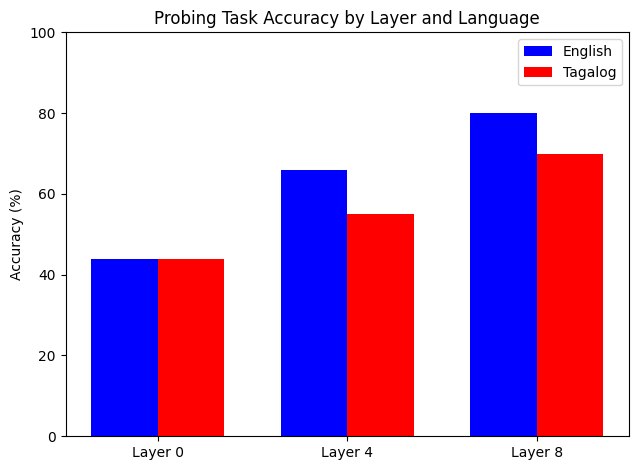

In [23]:
# plot accuracies in a bar plot
import matplotlib.pyplot as plt

layers = ['Layer 0', 'Layer 4', 'Layer 8']
accuracies_english = np.array([acc_english_0 * 100, acc_english_4 * 100, acc_english_8 * 100])
accuracies_tagalog = np.array([acc_tagalog_0 * 100, acc_tagalog_4 * 100, acc_tagalog_8 * 100])
x = np.arange(len(layers))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracies_english, width,
                label='English', color='b')
rects2 = ax.bar(x + width/2, accuracies_tagalog, width,
                label='Tagalog', color='r')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('Probing Task Accuracy by Layer and Language')
ax.set_xticks(x)
ax.set_xticklabels(layers)
ax.legend()
fig.tight_layout()
plt.ylim(0, 100)
plt.show()

tools:

In [11]:
tagalog = """tr NN Mula sa isang lahing xenophobic na may natatanging kakayahang makihalubilo sa ibang mga species at pinipiling hindi gawin ito, ang bounty hunter ay isang naglalakad na kontradiksyon. tr NNS Kinilabutan ang kanyang balat sa pag-iisip pa lamang tungkol sa nakakatakot na karanasan. tr NNS Bukod dito, bihirang may mga saksi sa aktwal na yugto, puro mga pangyayari lamang bago at pagkatapos. tr NNS Ang mga uwak ay pinalibutan ako. tr NNS May mga kulay ng ginto at dilaw, at siyempre isang maliwanag na bahagi ng kulay kahel. tr NN Isang kiliti ng kamalayan ang dumaan sa kanyang gulugod, at dahan-dahan siyang lumingon. tr NN Ang kanyang amo ay tumakas kasama ang asawa nito sa loob ng ilang hapon nitong tag-init. tr NNS Ang iyong mga biyenang Mackenzie ay may masasamang reputasyon na iilang disenteng pamilya lamang ang nagnanais na makaugnayan. tr NNS " At pagkatapos ay isa sa mga nilalang ang lumapit sa pinto, at tinanong kami mula sa labas kung mayroon kaming mga kurtina. tr NNS Nagdagsaan ang mga tanong sa isipan ni Lorraine, at itinanong niya muna ang mga pinaka-importante. tr NNS Ano ang ipinakita ng iyong mga pagsusuri? " tr NNS Mga bagay na idinulot ko sa isang hatak ng bagting ng aking pana. tr NNS Ang mga ideyang ito ay umiiral na noong panahong iyon mula sa Hinduismo. tr NNS Halos isang dosenang mainit na bala ang bumaon sa sternum at tiyan ng dayuhan, gaya ng nangyari sa ilang iba pang sinaunang sundalo. tr NNS Ang mga sahig na marmol sa foyer ay parang mga yelo sa ilalim ng kanyang mga paa. tr NN Tumigil ang van sa simbahan at bumaba ang lahat. tr NNS Ang mga Shadowhunter ay hindi kumakapit sa iisang relihiyon, at sa halip ay lahat ng relihiyon ay tumutulong sa amin sa aming laban. tr NNS Pinatay ni Cadmus ang dragon ni Ares nang hindi alam kung sino ang nagmamay-ari nito at nagdulot ito ng malaking gulo sa Olympus. tr NNS Ang ibang mga gang ay agad na napasailalim sa kontrol ni Chairman Z. tr NN Ang paminsan-minsang gantimpala ay mas mabuti kaysa sa walang gantimpala sa lahat. tr NNS Ang kalmadong tubig ay itim, gaya ng langit, na may tuldok-tuldok ng libu-libo (milyon-milyon?) tr NNS Tatlong titik ang nagliwanag sa isang malambot na phosphorescence laban sa madilim na semento. tr NNS Ang mga oras ay maaaring pekein, siyempre, pero... Paano kung ang mga imahe ay totoo? tr NN Kung mayroon mang panahon para magpakasaya, ang bakasyong ito na dapat iyon. tr NNS Ang mga kalokohan na gustong gawin ng ating mga kabataan at ambisyoso, na pinaka-ayaw natin, ay ang mga pagdukot. tr NN Sa tapat na pader ay may isang malaking flat screen TV na nakakabit sa mga dingding. tr NNS Mukhang nakabukas ang ilaw sa kusina. " tr NNS Ang kanyang bako-bakong kutson ay nag-iwan ng mga buhol sa kanyang mga balikat, isang pakiramdam na hindi kakaiba sa mga gabing ginugol sa pagtulog sa kamalig sa kanilang tahanan. tr NN Bumabagsak ang rampa nang may mas malakas na kalabog habang umaatras ako mula sa upuan at huling sumusunod sa mainit na buhangin na naririnig ko. tr NN " Inaakala kong wala itong idudulot na mabuti, pero magsalita ka, " sabi ng kolonel. tr NNS " Ano ang tsansa na makapasok siya sa Unibersidad pagkatapos ng paaralang ito ninyo? " tr NN Gaano kabilis mawawala ang epekto ng vodka? tr NNS " Dalawang iba pang priyoridad para maging tumpak, Madam Executive. tr NN Gusto ng Master ng impormasyon, at mas mabilis itong makukuha ng dalawa sa atin kaysa sa isa. ' tr NNS " Well, " sabi ni Ferguson, " Hindi naman talaga sinabi ng mga alamat. tr NNS May mga bagay na mapapansin. tr NN Ang tito ko ay highway patrolman pa rin sa California. tr NNS Hindi pa rin mabasa ang iniisip ni Romulus. tr NNS Sabi sa aming direksyon ay kumaliwa pagkatapos ng ikalawang Tourist Island. tr NN Hindi lang basta malakas na tawa, tandaan mo. tr NNS Ang mga kapitan ng kanyang tito ay matatag na tumatango, pati na rin ang marami sa magkabilang mesa. tr NN Ang teorya ko ay mahal ko na siya bago ko pa man siya nakilala. tr NNS Malapit nang maging mahirap ang mga bagay-bagay. tr NNS Naging sobrang liksi ng mga galaw ng babae kaya may malinaw na posibilidad na matamaan siya. tr NNS Ang mga katulong, na nakahula naman, ay hindi kailanman mangangarap na isumbong ang batang magkasintahan. tr NN Ikinuskos ng gagamba ang kanyang mga harapang binti sa kanyang dibdib na tila tumutugtog ng alpa. tr NN " Linggo, Kim, " sabi ni Jared, habang tinatawag siya. tr NNS Gayundin, may libu-libong tao na pabalik-balik sa loob ng pyramid city, kaya walang anumang masusundan. tr NN Pero bumalik na ang kuryente. tr NNS Mayroon ding mga poster ng likhang-sining ng mga estudyante, mga larawan ng mga hayop, mga self-portrait, mga eksena ng kalikasan at mga kung anu-anong bagay. tr NNS Ang mga galaw ay napaka-swabe habang ginagamit niya ang mga ito at hinahayaang bumalik sa loob ng kanilang metal na lalagyan. tr NN at sa wakas ay narating ang hantungan. tr NN Kung totoo, marahil ang suspek ay nakapagbigay ng impormasyon tungkol sa tatlo pang nawawalang babae. tr NNS Nawawala na ang epekto ng alak pero hindi siya nabawasan ng lakas ng loob. tr NN Kabanata 8 At doon natagpuan ni Antonia ang kanyang sarili sa isa pang kakaibang lugar at panahon. tr NNS Huminga nang malalim si Hephaestus at mabilis na isinulat ang kanyang pangalan. tr NN Wala itong kabuluhan. tr NNS Ang mga EMP grenade ay matibay laban sa sarili nilang epekto, kaya dapat gumana pa ang iba. tr NNS Tumatalbog ang mga suso ni Clara sa bawat kislot ng kanyang balakang habang bumaon siya nang malalim sa kanya. tr NN Ang aking Master ay hindi kailanman naging mabait sa akin noong bata pa ako, at wala akong naging mga kaibigan. tr NN Ang tanging basura dito ay ang walang kwentang taba na iyan. " tr NNS Binalewala ng mga android na nars si Alessia nang pumasok siya para makita ang kanyang ama. tr NN Isang mabalahibo ngunit payat na abong kuting na may mapuputing paa ang umiikot sa kanyang mga paa. tr NNS " Pero ang mga nilalang na gaya niyan ay hindi kailanman humabol sa akin noon. tr NNS Ang mga lobo ay paikot-ikot nang hindi mapakali, ang kanilang nagniningning na dilaw na mga mata ay nakatuon sa pinto ng driver. tr NNS Ang anim na iba pang miyembro ng board na naroroon ay sang-ayon lahat sa agad na pagpapatalsik sa babae. tr NNS May ilang patak ng kung anuman iyon. tr NNS Paulit-ulit na pumasok at lumabas ang mga disc sa kanila hanggang sa bumagsak sila sa lupa na naglalagablab. tr NN Kung si Josie ay suot pa rin ang manipis na damit panloob, hindi maganda ang tsansa na mapigilan ko ang aking mga kamay. tr NNS Mga dire wolf, marahil, na nakulong dito sa loob ng libu-libong taon dahil sa mataas na tubig sa kuweba. " tr NNS " Well, noong una itong ikinulong, maraming labasan ang iniwan. tr NNS Kalaunan ay tuluyan nang huminto ang kanyang mga pagbisita. " tr NN Isang bagong determinasyon ang tumulong upang pigilan ang kanilang takot habang humaharap sila sa liwanag at nagpatuloy. tr NNS Ang dalawang naka-amerikana na may mga radyo sa kabilang panig ng lounge ay nanatiling nakatuon sa ibaba, habang nakikipag-usap sa kanilang mga radyo. tr NN Hablot ng receptionist ang folder mula sa kanyang bar. tr NNS Binombahan ng mga kulay ang aking ulo, at napahiyaw ako sa matinding sakit. tr NNS Inilagay ko ang sulat sa unan sa tabi niya, pagkatapos ay isinulat sa likod ng aking kamay ang "walang pagsisisi". tr NN Binigyan siya ng isang galit na tingin, at nagawang patahimikin ni Link ang diwata sa ngayon. tr NNS Ang mga dilaw at hugis-kampanang bulaklak ay nakabitin sa tangkay, na nagpapatong-patong sa isa't isa. tr NN " Malapit ang bumaril, at hindi ko maaaring isapalaran na barilin ka niya. " tr NNS Naging medyo abala ang mga bagay-bagay. " tr NN Ang garahe mismo ay napaka-ayos, lahat ng mga kagamitan ay nakahanay sa isang simpleng kahoy na mesa na kasinghaba ng silid. tr NN Ang paglalarawang ibinigay ng may-ari ng gallery tungkol sa kanyang Richard Wolsey Keen ay hindi tumutugma sa iyo. tr NNS May mga yabag, at nagpinta siya ng ngiti sa kanyang mukha. tr NNS Pinintahan ng mga mandirigma ang kanilang mga mukha gamit ang apat na daliri na isinawsaw sa pintura. tr NNS Nagpatuloy ang pag-record ng mga camera. tr NN Kapag nagawa na at naka-lock na ang koneksyon, sasabihin ng boom operator, "contact". tr NNS Swabeng lumabas mula sa madilim na paligid patungo sa liwanag, tatlong tila multong pigura ang lumitaw, tahimik na dumadausdos gamit ang skis. tr NN Nagulat siya sa hamon sa kanyang tinig. tr NNS Ang mga Lost Soul ay... well, hindi sila ang pinakamagandang nilalang sa mundo. tr NNS Nanaig sa akin ang kalungkutan, at sa isang sandali ang tanging gusto ko lang ay lumubog sa nakapalibot na hamog at maglaho. tr NN Siguro ay pwedeng i-sponsor ako ng garahe. " tr NN Bukod sa mental na migraine, ang baho ng alak na humalo sa dumi ng tao ay nakakasuka. tr NNS Maliban na sa pagkakataong ito, ang mga imahe ay hindi lamang mula sa kanyang buhay, kundi mula sa buhay ng hindi mabilang na iba pa. tr NNS Dalawang panahon na ang lumipas simula nang nanirahan kami sa ilalim ng mga dagat na bumabalot sa malaking bahagi ng ating planeta. tr NN Namaga ang tama sa aking pisngi, na tila ba ang kulog ay dinudurog ng kidlat. tr NNS Ang iba ay nanginginig sa lagnat, ang kanilang kutis ay maputla, halos kulay berde. tr NN " Hawak nila ang kontrol, " tawag ng piloto pabalik kay Winston. tr NNS May ilang magagandang bar sa Dunedin, kung pupunta ka sa Octagon. tr NN Interesanteng obserbasyon, lalo na't ang lalaki ay tila isang mapanganib at nakukurner na hayop, nakamamatay sa anumang provokasyon."""

# split the text on the space before "tr"
sentences = ["tr " + s for s in tagalog.split(" tr ") if s]

# add /t instead of space for the first two spaces of each line
sentences = [s.replace(" ", "\t", 2) for s in sentences]

# save raw sentences to a file
with open("tagalog_sentences.txt", "w", encoding="utf-8") as f:
        for sentence in sentences:
            f.write(sentence.strip() + "\n")

In [12]:
sentences

['tr\ttr\tNN Mula sa isang lahing xenophobic na may natatanging kakayahang makihalubilo sa ibang mga species at pinipiling hindi gawin ito, ang bounty hunter ay isang naglalakad na kontradiksyon.',
 'tr\tNNS\tKinilabutan ang kanyang balat sa pag-iisip pa lamang tungkol sa nakakatakot na karanasan.',
 'tr\tNNS\tBukod dito, bihirang may mga saksi sa aktwal na yugto, puro mga pangyayari lamang bago at pagkatapos.',
 'tr\tNNS\tAng mga uwak ay pinalibutan ako.',
 'tr\tNNS\tMay mga kulay ng ginto at dilaw, at siyempre isang maliwanag na bahagi ng kulay kahel.',
 'tr\tNN\tIsang kiliti ng kamalayan ang dumaan sa kanyang gulugod, at dahan-dahan siyang lumingon.',
 'tr\tNN\tAng kanyang amo ay tumakas kasama ang asawa nito sa loob ng ilang hapon nitong tag-init.',
 'tr\tNNS\tAng iyong mga biyenang Mackenzie ay may masasamang reputasyon na iilang disenteng pamilya lamang ang nagnanais na makaugnayan.',
 'tr\tNNS\t" At pagkatapos ay isa sa mga nilalang ang lumapit sa pinto, at tinanong kami mula sa